In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pickle
import os

SavingFolder = os.path.join(os.getcwd(), 'SavingFolder')

import imageio
import re

In [3]:
def apply_Tooms_rule_with_loss(spins, lost_cells, p=0, q=0, NEC_directions = 'Random'):
    #The line below applies the Toom's rule variant when considering lost cells. 
    #Cells in -1 spin are in 0, Cells in +1 spin have value 2, lost Cells have value 1
    
    """
    This implements the following rule which attempts to generalise Toom's rule in presence of losses: 
    If the NE (or any chosen directions) neighbours of a cell are both different from C or lost, 
    and at least one is different from C, than flip C.
    To make this work, it is necessary to change directions on which the rule is applied often (but not too often)
    otherwise you get quickly stuck as soon as NE are both lost.
    
    Changing directions randomly every ~10 updates seems to work well preppy much for every loss, 
    probably making it loss dependent, i.e. longer when loss probability is low (and/or error prob is high) 
    and shorter when loss is high (and/or error prob is low),  could improve things. To be chenked.
    
    With these tricks, the cellular automaton seems to work decently in presence of loss.
    """
    
    if type(NEC_directions) is np.ndarray:
    
        h_dir, v_dir = NEC_directions
        NEC_func = np.roll(spins, h_dir, axis=0) + np.roll(spins, v_dir, axis=1)


    elif NEC_directions == 'Random': 
        
        ###### Randomizes between N-S and W-E for the update direction to avoid blocks with losses
        ###### Seems to slow the correction down a bit though

        h_dir, v_dir = (-1)**np.random.binomial(1, 0.5, 2)
        NEC_func = np.roll(spins, h_dir, axis=0) + np.roll(spins, v_dir, axis=1)
        
#         ###### Randomizes only the choice NE or NW
#         ###### Does not shrink the error.

#         ax_dir = (-1)**np.random.binomial(1, 0.5)
#         NEC_func = np.roll(spins, 1, axis=0) + np.roll(spins, -1*ax_dir, axis=1)


#         ###### Randomizes only the choice NE or SW
#         ###### Does not shrink the error.

#         ax_dir = (-1)**np.random.binomial(1, 0.5)
#         NEC_func = np.roll(spins, 1*ax_dir, axis=0) + np.roll(spins, -1*ax_dir, axis=1)

    else:
        
        ###### No randomization, always NE
        NEC_func = np.roll(spins, 1, axis=0) + np.roll(spins, -1, axis=1)

    # Function that just maps 0,1 -> 1 ; 2 -> 2; 3, 4 -> 4. 
    # Not sure it is the best way to do it, but it's what I came up with.
    NEC_func = ((NEC_func + (NEC_func - 2)*(NEC_func%2))/2).astype(np.uint8) 
    
    # Where the NEC function is 2, just keep the same spin in C. If > 2 make C 2, if <2 make C 0.
    new_spins = np.where(NEC_func%2, spins, NEC_func)
    
    if p>0:
        if q>0:
            new_spins = (new_spins + np.random.binomial(new_spins, p).astype(np.uint8) + np.random.binomial(1-new_spins, q).astype(np.uint8))%2
        else:
            new_spins = (new_spins + np.random.binomial(new_spins, p).astype(np.uint8)) % 2
    elif q>0:
        new_spins = (new_spins + np.random.binomial(1-new_spins, q).astype(np.uint8))%2   

    # reset lost cells
    new_spins[lost_cells] = 1
        
        
    return new_spins

def sample_lost_cells(L, p_loss):
    lost_cells_ixs = np.where(np.random.binomial(1, p_loss, L**2))[0]
    return ([ int(ix/L) for ix in lost_cells_ixs], [ ix%L for ix in lost_cells_ixs])


def get_pq_from_Th(T, h):
    return T*(1.+h)*0.5, T*(1.-h)*0.5 

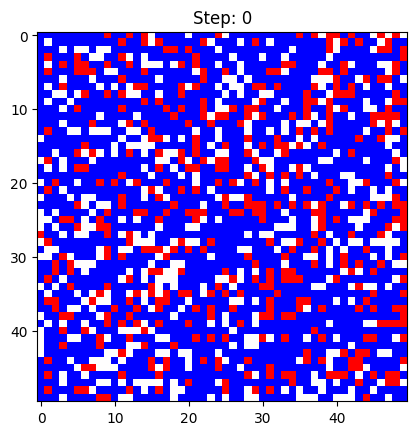

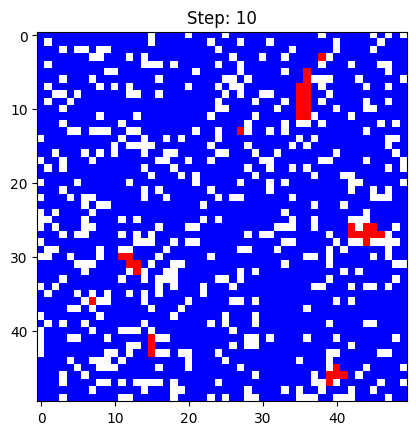

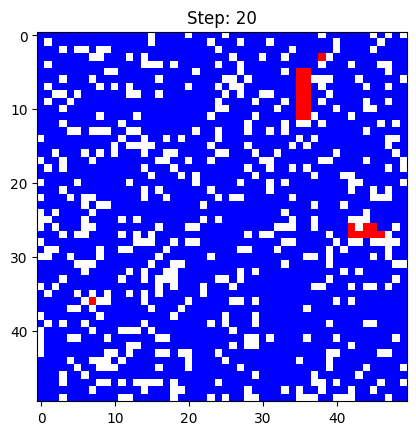

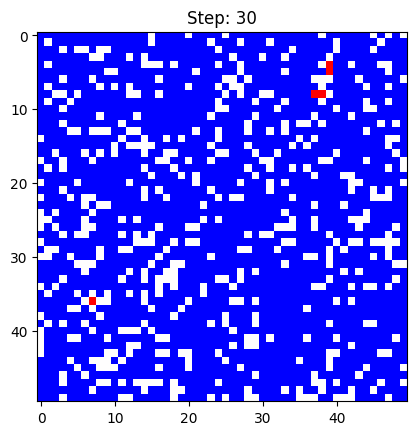

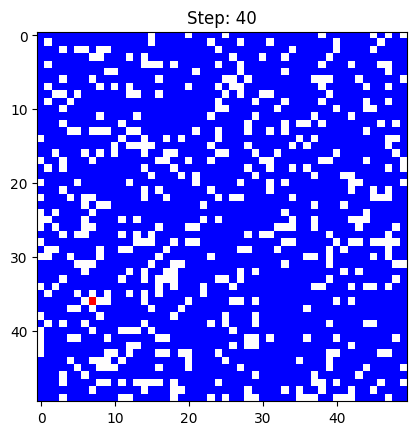

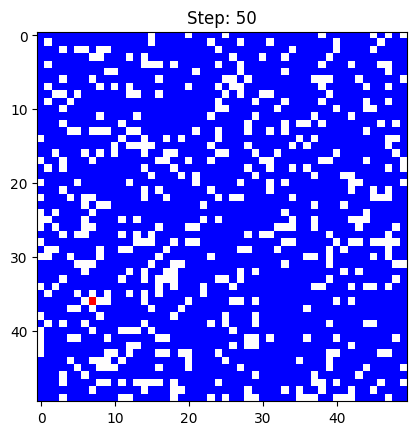

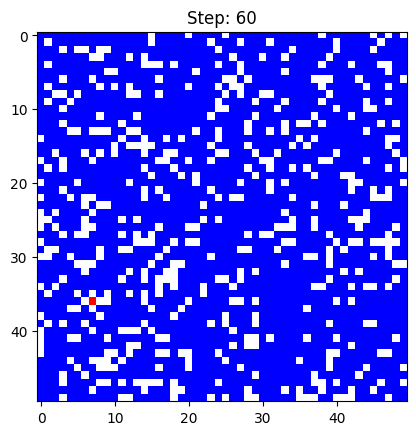

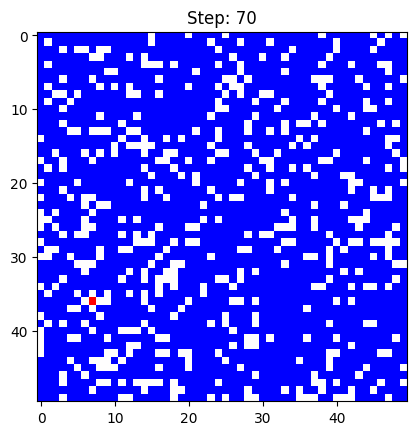

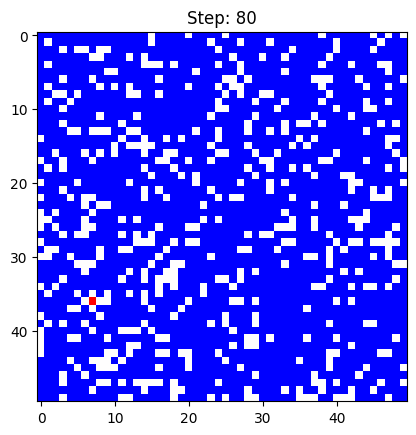

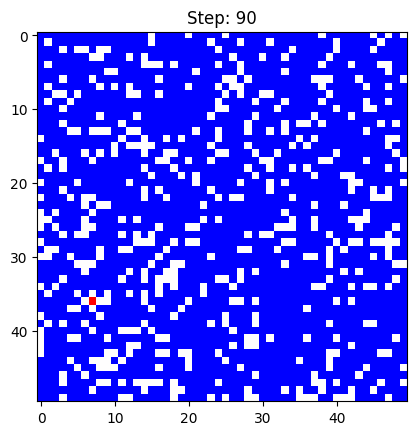

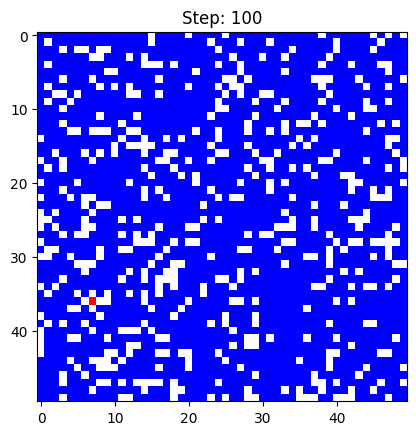

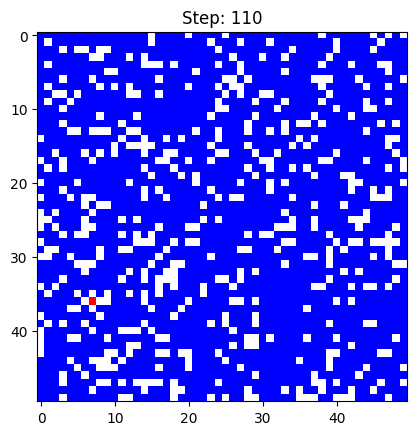

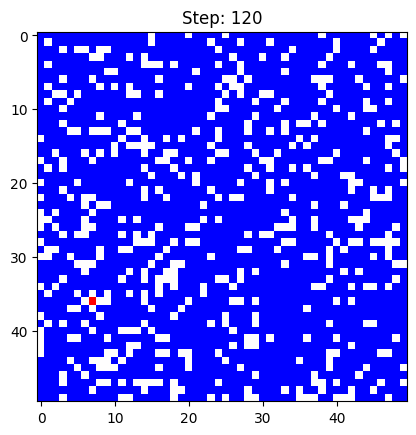

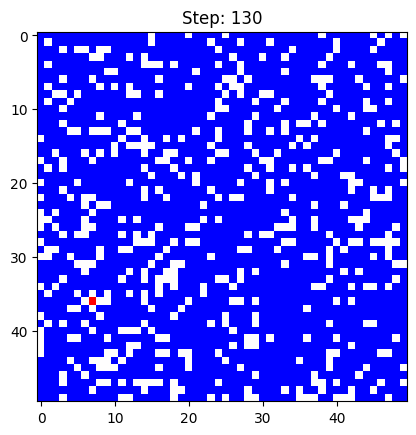

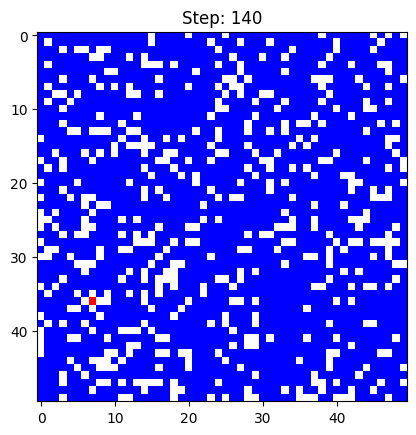

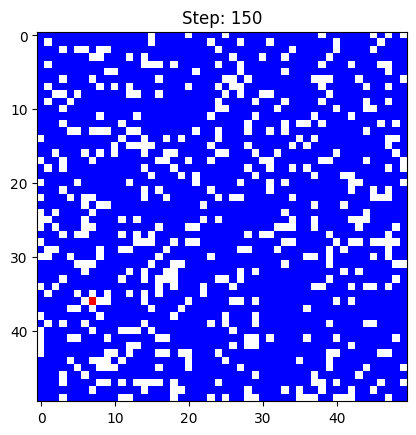

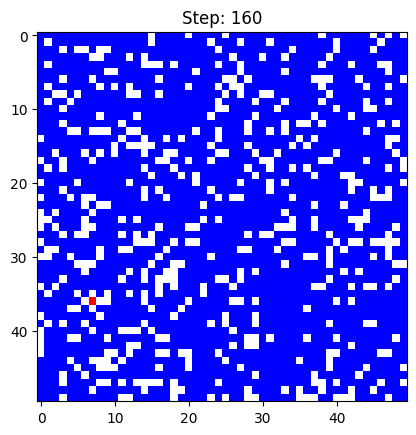

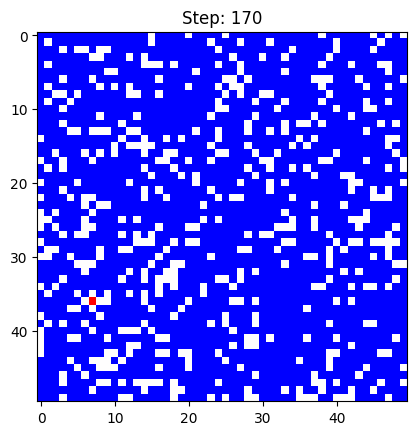

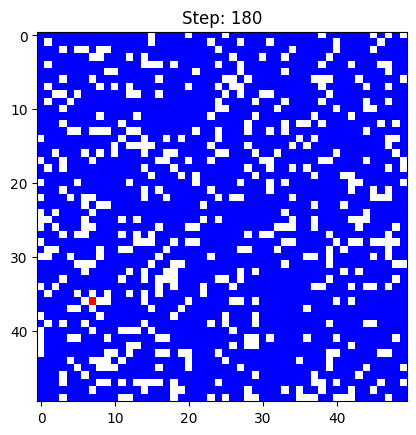

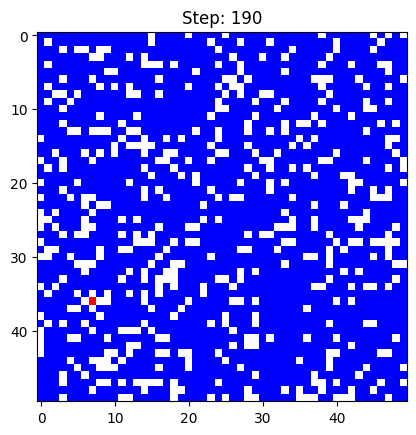

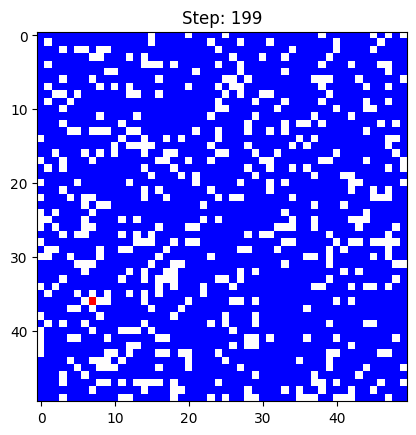

In [4]:
L = 50

# T = 0.05
# h = -0.1

# p, q = get_pq_from_Th(T, h)

p_loss = 0.2 #0.1

num_steps = 200

plot_every = 10

init_bias = 0.80


randomized_dirs_every = 5 #10

if np.random.binomial(1, 0.5)>0.5:
    init_bias = init_bias
else:
    init_bias = 1 - init_bias


spins = np.random.binomial(1, init_bias, (L, L)).astype(np.uint8) * 2
lost_cells = sample_lost_cells(L, p_loss)
spins[lost_cells] = 1



for step_ix in range(num_steps):
    
    if (step_ix%randomized_dirs_every)==0:
        NEC_directions = (-1)**np.random.binomial(1, 0.5, 2)
        
    
    if (step_ix % plot_every == 0):
        fig  = plt.figure()
        plt.imshow(spins, cmap='bwr', vmin=0, vmax=2)
        plt.title('Step: '+str(step_ix))
        plt.show()

    spins = apply_Tooms_rule_with_loss(spins, lost_cells, p=0, q=0, NEC_directions = NEC_directions)

plt.imshow(spins, cmap='bwr', vmin=0, vmax=2)
plt.title('Step: '+str(step_ix))
plt.show()

# Save plots to make gif from evolution

In [5]:
L = 100

# T = 0.05
# h = -0.1

# p, q = get_pq_from_Th(T, h)

p_loss = 0.15 #0.1

num_steps = 200

plot_every = 2

init_bias = 0.75


randomized_dirs_every = 10 #20 # 5



####### Clean saving folder

for file in os.listdir(os.path.join(SavingFolder, './gif_img/')):
    os.remove(os.path.join(SavingFolder, './gif_img/', file))

####### Do scan


if np.random.binomial(1, 0.5)>0.5:
    init_bias = init_bias
else:
    init_bias = 1 - init_bias


spins = np.random.binomial(1, init_bias, (L, L)).astype(np.uint8) * 2
lost_cells = sample_lost_cells(L, p_loss)
spins[lost_cells] = 1



for step_ix in range(num_steps):
    
    if (step_ix%randomized_dirs_every)==0:
        NEC_directions = (-1)**np.random.binomial(1, 0.5, 2)
    
    
    if (step_ix % plot_every == 0):
        fig  = plt.figure()
        plt.imshow(spins, cmap='bwr', vmin=0, vmax=2)
        plt.title('p_loss ='+str(p_loss)+', randdir steps ='+str(randomized_dirs_every)+', Step: '+str(step_ix))
        plt.savefig(os.path.join(SavingFolder, f'./gif_img/img_{step_ix}.png'), 
                    transparent = False,  
                    facecolor = 'white'
                   )
        plt.close()

    spins = apply_Tooms_rule_with_loss(spins, lost_cells, p=0, q=0, NEC_directions=NEC_directions)

fig  = plt.figure()
plt.imshow(spins, cmap='bwr', vmin=0, vmax=2)
plt.title('p_loss ='+str(p_loss)+', randdir steps ='+str(randomized_dirs_every)+', Step: '+str(step_ix))
plt.savefig(os.path.join(SavingFolder, f'./gif_img/img_{step_ix}.png'), 
            transparent = False,  
            facecolor = 'white'
           )
plt.close()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\ip19160\\PycharmProjects\\EC_sims\\SteTests\\SavingFolder\\./gif_img/'

In [ ]:
frames = []

steps_list = []

for file in os.listdir(os.path.join(SavingFolder, './gif_img/')):
    if file.endswith(".png"):
        num_steps = int(re.search('img_(.*).png', file).group(1))
        steps_list.append(num_steps)
             
        
for step_ix in np.sort(steps_list):
        image = imageio.v2.imread(os.path.join(SavingFolder, f'./gif_img/img_{step_ix}.png'))
        frames.append(image)
        
imageio.mimsave(os.path.join(SavingFolder, './ToomsWithLoss.gif') , 
                frames, 
                fps = 10, 
                loop = 1)